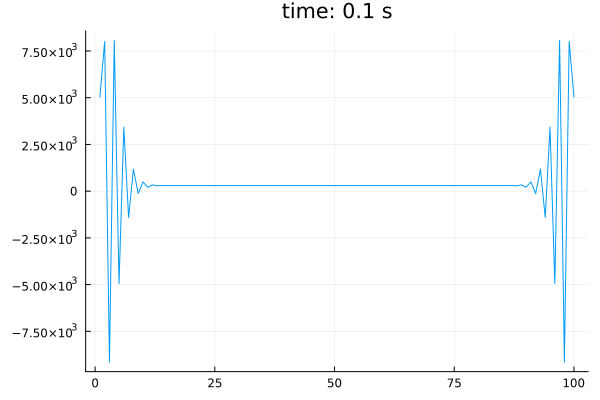

In [4]:
using LinearAlgebra
using Plots

# Basic parameters
# nt = 2000    # Number of time steps
vs = 3000    # Wave velocity [m/s] 
ro0 = 2500    # Density [kg/m^3]
nx = 100    # Number of grid points  
xmax = 10000.0  # Maximum length
t_max = 0.1    # Maximum time
eps = 0.01     # Stability limit
iplot = 1      # Snapshot frequency

dx = xmax / (nx - 1)           # calculate space increment
x = range(0, stop=nx - 1) * dx   # initialize space coordinates
x = transpose(x)
h = diff(vec(x) )                    # calculate the element sizes)

# parameters
ro = x * 0 .+ ro0
mu = x * 0 .+ ro .* vs .^ 2

# time step from stability criterion
dt = eps * dx / maximum(sqrt.(mu ./ ro))

nt = round(Int, t_max / dt)   # calculate number of time steps
# println(vs * dt / dx, "  ", nt)

# initialize time axis
t = range(dt, stop=nt * dt, length=nt)

# 
u = ones(nx)
uold = zeros(nx)
unew = zeros(nx)

p = zeros(nx)
pold = zeros(nx)
pnew = zeros(nx)

# Source term (simple Ricker wavelet)
function ricker_wavelet(t, f; tau=2.0)
    wavelet = sin.(2.0 * pi * f * t)
    return wavelet
end

# Mass matrix M_ij
M = zeros(nx, nx)
for i in 2:nx-1
    for j in 2:nx-1
        if j == i
            M[i, j] = (ro[i-1] * h[i-1] + ro[i] * h[i]) / 3
        elseif j == i + 1
            M[i, j] = ro[i] * h[i] / 6
        elseif j == i - 1
            M[i, j] = ro[i-1] * h[i-1] / 6
        else
            M[i, j] = 0
        end
    end
end

# Corner elements
M[1, 1] = ro[1] * h[1] / 3
M[nx, nx] = ro[nx] * h[nx-1] / 3

# Invert M
Minv = inv(M)

# heatmap(Minv, title="Mass Matrix M", color=:viridis, legend=false)

# Stiffness matrix Kij
K = zeros(nx, nx)
for i in 2:nx-1
    for j in 2:nx-1
        if j == i
            K[i, j] = mu[i-1] / h[i-1] + mu[i] / h[i]
        elseif j == i + 1
            K[i, j] = -mu[i] / h[i]
        elseif j == i - 1
            K[i, j] = -mu[i-1] / h[i-1]
        else
            K[i, j] = 0
        end
    end
end

# Corner elements
K[1, 1] = mu[1] / h[1]
K[nx, nx] = mu[nx-1] / h[nx-1]

# heatmap(K, title="Stiffness Matrix K", color=:viridis, legend=false)

u_time = zeros(nt, nx)
for it in 1:nt
    unew = (dt^2) * Minv * (K * u) + 2*u - uold     
    
    # Source term (explosion)
    # unew[round(Int, nx/2)] += ricker_wavelet(t[it], 1.0, tau=0.1)

    uold, u = u, unew

    u_time[it, :] = u
    # if it % 10 == 0
    #     IJulia.clear_output(true)
    #     p = plot(u, legend=false, title="time: $(it*dt) s")
        # plot!(x, p, color=:red, linewidth=1.5)
        # title!("Solution at t = $(it*dt)")
    #     display(p)
    # end

end

max_u = maximum(u_time)
min_u = minimum(u_time)

# println(u_time[nt, :])

# display
for it in 1:nt
#     # if it % iplot == 0
        IJulia.clear_output(true)
        p = plot(u_time[it, :], legend=false, title="time: $(it*dt) s", #= ylims=(min_u, max_u) =#)
#         title!("Solution at t = $(it*dt)")
        display(p)
#     # end
end
